# Import

In [1]:
import numpy as np
import pandas as pd
import catboost as cb
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import optuna
import pickle

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/r_3.xlsx
/kaggle/input/r_2.xlsx
/kaggle/input/sklad.xlsx


# Data

In [2]:
df_1 = pd.read_excel('/kaggle/input/sklad.xlsx')
df_2 = pd.read_excel('/kaggle/input/r_2.xlsx')
df_3 = pd.read_excel('/kaggle/input/r_3.xlsx')

In [3]:
df_2 = df_2.merge(df_1, on = 'FF', how = 'left')
df_3 = df_3.merge(df_1, on = 'FF', how = 'left')

In [4]:
df_2

,day_id,FF,return_2_0_items,Регион,Тип склада
0,2024-03-22,Склад 1001,1498,Юг,Обычный
1,2022-11-03,Склад 1002,151,Юг,Обычный
2,2023-07-12,Склад 1003,12,СНГ,Обычный
3,2023-03-11,Склад 1004,4716,Москва,Обычный
4,2022-08-27,Склад 1005,214,Волга,Обычный
...,...,...,...,...,...
17248,2023-07-12,Склад 1004,2377,Москва,Обычный
17249,2023-01-31,Склад 1022,469,СПб,Обычный
17250,2022-12-01,Склад 1007,569,Москва,Обычный
17251,2023-11-21,Склад 1015,2,Москва,Обычный


In [5]:
df_3

,day_id,FF,returns_3_0_items,Регион,Тип склада
0,2024-04-24,Склад 1018,922,СПб,Обычный
1,2023-11-20,Склад 1032,240,Москва,Обычный
2,2024-03-31,Склад 1030,42,Дальний Восток,Обычный
3,2024-03-19,Склад 1015,227,Москва,Обычный
4,2024-02-08,Склад 1005,115,Волга,Обычный
...,...,...,...,...,...
5185,2024-05-27,Склад 1035,1757,Москва,Обычный
5186,2024-05-25,Склад 1022,1,СПб,Обычный
5187,2023-12-28,Склад 1006,185,Юг,Обычный
5188,2024-05-31,Склад 1015,857,Москва,Обычный


# EDA

In [6]:
group_2 = df_2.groupby('day_id').agg({
    'return_2_0_items' : 'mean'
}).reset_index()

group_3 = df_3.groupby('day_id').agg({
    'returns_3_0_items' : 'mean'
}).reset_index()

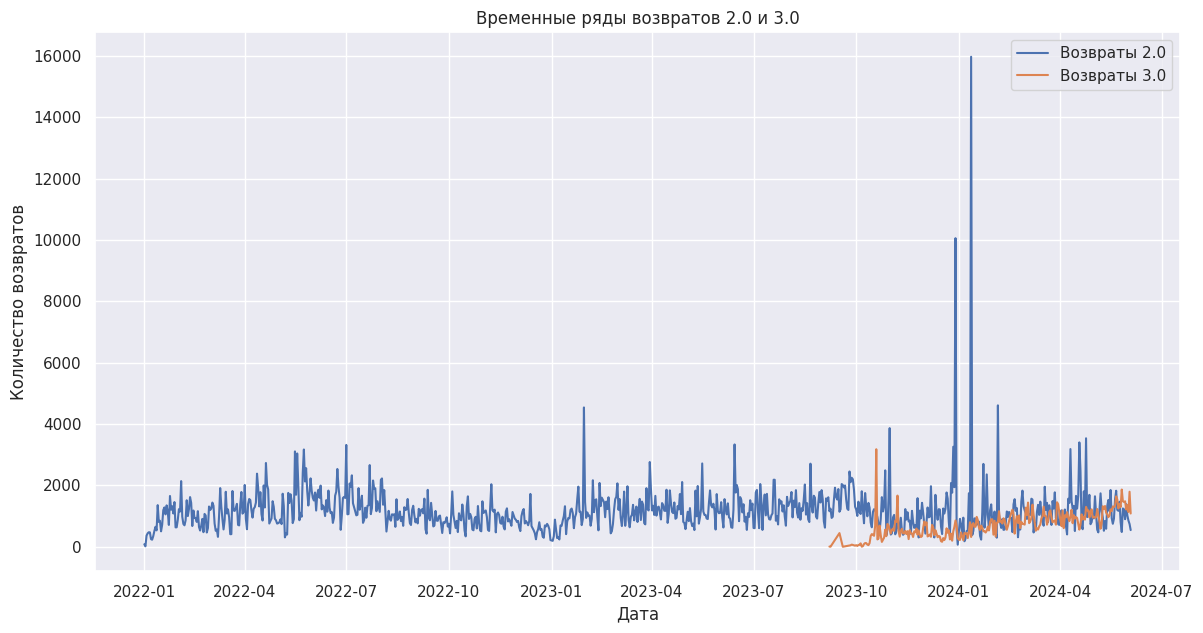

In [7]:
sns.set(style="darkgrid")

plt.figure(figsize=(14, 7))
plt.plot(group_2['day_id'], group_2['return_2_0_items'], label='Возвраты 2.0')
plt.plot(group_3['day_id'], group_3['returns_3_0_items'], label='Возвраты 3.0')
plt.xlabel('Дата')
plt.ylabel('Количество возвратов')
plt.title('Временные ряды возвратов 2.0 и 3.0')
plt.legend()
plt.show()

# Clear Outliers

In [8]:
df_2 = df_2[(df_2['return_2_0_items'] <= 40000)]
df_3 = df_3[(df_3['returns_3_0_items'] <= 20000)]

group_2 = df_2.groupby('day_id').agg({
    'return_2_0_items' : 'mean'
}).reset_index()

group_3 = df_3.groupby('day_id').agg({
    'returns_3_0_items' : 'mean'
}).reset_index()

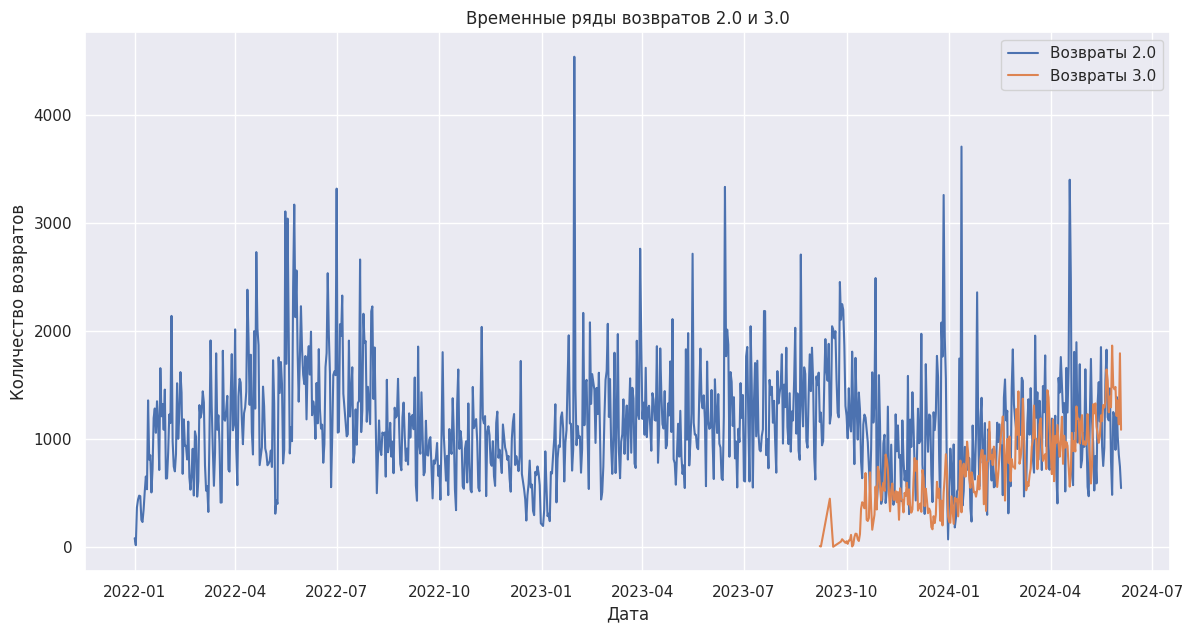

In [9]:
sns.set(style="darkgrid")

plt.figure(figsize=(14, 7))
plt.plot(group_2['day_id'], group_2['return_2_0_items'], label='Возвраты 2.0')
plt.plot(group_3['day_id'], group_3['returns_3_0_items'], label='Возвраты 3.0')
plt.xlabel('Дата')
plt.ylabel('Количество возвратов')
plt.title('Временные ряды возвратов 2.0 и 3.0')
plt.legend()
plt.show()

# Generate Time Features

In [10]:
df_2['day_of_week'] = df_2['day_id'].dt.dayofweek
df_2['month'] = df_2['day_id'].dt.month
df_2['quarter'] = df_2['day_id'].dt.quarter
df_2['day_of_month'] = df_2['day_id'].dt.day
df_2['day_of_year'] = df_2['day_id'].dt.dayofyear
df_2['week_of_year'] = df_2['day_id'].dt.isocalendar().week
df_2['is_week_even'] = df_2['day_id'].dt.isocalendar().week % 2 == 0
df_2['year'] = df_2['day_id'].dt.year
df_2['is_weekend'] = df_2['day_id'].dt.dayofweek >= 5
df_2['season'] = df_2['day_id'].apply(lambda x: (x.month%12 + 3)//3)

df_3['day_of_week'] = df_3['day_id'].dt.dayofweek
df_3['month'] = df_3['day_id'].dt.month
df_3['quarter'] = df_3['day_id'].dt.quarter
df_3['day_of_month'] = df_3['day_id'].dt.day
df_3['day_of_year'] = df_3['day_id'].dt.dayofyear
df_3['week_of_year'] = df_3['day_id'].dt.isocalendar().week
df_3['is_week_even'] = df_3['day_id'].dt.isocalendar().week % 2 == 0
df_3['year'] = df_3['day_id'].dt.year
df_3['is_weekend'] = df_3['day_id'].dt.dayofweek >= 5
df_3['season'] = df_3['day_id'].apply(lambda x: (x.month%12 + 3)//3)

season_dict = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df_2['season'] = df_2['season'].map(season_dict)
df_3['season'] = df_3['season'].map(season_dict)

In [11]:
holiday_dates = [
    "1 January",
    "2 January",
    "3 January",
    "4 January",
    "5 January",
    "6 January",
    "7 January",
    "8 January",
    "23 February",
    "8 March",
    "1 May",
    "9 May",
    "12 June",
    "4 November"
]

holiday_set = set(holiday_dates)

def is_holiday(day):
    date_str = day.strftime("%-d %B")
    return date_str in holiday_set

df_2['is_holiday'] = df_2['day_id'].apply(lambda x: 1 if is_holiday(x) else 0)
df_3['is_holiday'] = df_3['day_id'].apply(lambda x: 1 if is_holiday(x) else 0)

In [12]:
df_2.head()

,day_id,FF,return_2_0_items,Регион,Тип склада,day_of_week,month,quarter,day_of_month,day_of_year,week_of_year,is_week_even,year,is_weekend,season,is_holiday
0,2024-03-22,Склад 1001,1498,Юг,Обычный,4,3,1,22,82,12,True,2024,False,Spring,0
1,2022-11-03,Склад 1002,151,Юг,Обычный,3,11,4,3,307,44,True,2022,False,Fall,0
2,2023-07-12,Склад 1003,12,СНГ,Обычный,2,7,3,12,193,28,True,2023,False,Summer,0
3,2023-03-11,Склад 1004,4716,Москва,Обычный,5,3,1,11,70,10,True,2023,True,Spring,0
4,2022-08-27,Склад 1005,214,Волга,Обычный,5,8,3,27,239,34,True,2022,True,Summer,0


In [13]:
df_3.head()

,day_id,FF,returns_3_0_items,Регион,Тип склада,day_of_week,month,quarter,day_of_month,day_of_year,week_of_year,is_week_even,year,is_weekend,season,is_holiday
0,2024-04-24,Склад 1018,922,СПб,Обычный,2,4,2,24,115,17,False,2024,False,Spring,0
1,2023-11-20,Склад 1032,240,Москва,Обычный,0,11,4,20,324,47,False,2023,False,Fall,0
2,2024-03-31,Склад 1030,42,Дальний Восток,Обычный,6,3,1,31,91,13,False,2024,True,Spring,0
3,2024-03-19,Склад 1015,227,Москва,Обычный,1,3,1,19,79,12,True,2024,False,Spring,0
4,2024-02-08,Склад 1005,115,Волга,Обычный,3,2,1,8,39,6,True,2024,False,Winter,0


# Features List

In [14]:
target_2 = 'return_2_0_items'
features_2 = ['FF', 'Регион', 'Тип склада','day_of_week', 'month', 'quarter', 
              'day_of_month', 'day_of_year', 'week_of_year', 'is_week_even', 
              'year', 'is_weekend', 'season', 'is_holiday']
cat_features_2 = ['FF', 'Регион', 'Тип склада','is_week_even', 'is_weekend', 'season', 'is_holiday']

target_3 = 'returns_3_0_items'
features_3 = ['FF', 'Регион','day_of_week', 'month', 'quarter', 
              'day_of_month', 'day_of_year', 'week_of_year', 'is_week_even',
              'year', 'is_weekend', 'season', 'is_holiday']
cat_features_3 = ['FF', 'Регион','is_week_even', 'is_weekend', 'season', 'is_holiday']

# Split

In [15]:
df_2 = df_2.sort_values(by = 'day_id')
df_3 = df_3.sort_values(by = 'day_id')

In [16]:
df_2.shape[0], df_2[df_2['day_id'] >= '2024-01-01'].shape[0]/df_2.shape[0]

(17242, 0.24788307620925645)

In [17]:
df_3.shape[0], df_3[df_3['day_id'] >= '2024-04-01'].shape[0]/df_3.shape[0]

(5188, 0.3197764070932922)

In [18]:
X_train_2 = df_2[df_2['day_id'] < '2024-01-01'][features_2]
y_train_2 = df_2[df_2['day_id'] < '2024-01-01'][target_2]

X_test_2 = df_2[df_2['day_id'] >= '2024-01-01'][features_2]
y_test_2 = df_2[df_2['day_id'] >= '2024-01-01'][target_2]


X_train_3 = df_3[df_3['day_id'] < '2024-04-01'][features_3]
y_train_3 = df_3[df_3['day_id'] < '2024-04-01'][target_3]

X_test_3 = df_3[df_3['day_id'] >= '2024-04-01'][features_3]
y_test_3 = df_3[df_3['day_id'] >= '2024-04-01'][target_3]

# Boosting

In [19]:
class Boosting:

    def __init__(self, X_train, X_val, y_train, y_val, cat_features, params = None):
        print("Init...")
        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        self.cat_features = cat_features
        self.params = params
        self.model = None
        self.best_params = None
        self.top_features = None
        self.train_pool = cb.Pool(data = X_train, label = y_train, cat_features = cat_features)
        self.val_pool = cb.Pool(data = X_val, label = y_val, cat_features = cat_features)
        self.file_path = None
        print("Init Finished!")

    def train(self):
        if self.params is None:
            model = cb.CatBoostRegressor(
                depth = 4,
                loss_function = 'RMSE',
                task_type = 'CPU',
                iterations = 2000,
                use_best_model = True,
                verbose = 100,
                thread_count = -1,
                early_stopping_rounds = 100,
                eval_metric = 'R2'
            )
        else:
            self.params["verbose"] = 100
            model = cb.CatBoostRegressor(**self.params)

        model.fit(
            self.train_pool,
            eval_set = self.val_pool
        )

        y_train_pred = model.predict(self.X_train)
        y_val_pred = model.predict(self.X_val)

        mape_tr = mean_absolute_percentage_error(np.exp(self.y_train), np.exp(y_train_pred))
        mape_val = mean_absolute_percentage_error(np.exp(self.y_val), np.exp(y_val_pred))

        print("MAPE на TRAIN выборке:", mape_tr)
        print("MAPE на VALID выборке:", mape_val)

        self.model = model

    def optimize_hyperparams(self):

        def objective(trial):
            params = {
                "learning_rate" : trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
                "l2_leaf_reg" : trial.suggest_loguniform("l2_leaf_reg", 1e-2, 3e0),
                "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.01, 0.1, log = True),
                "depth" : trial.suggest_int("depth", 2, 5),
                "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
                "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 2, 50),
                "one_hot_max_size" : trial.suggest_int("one_hot_max_size", 2, 50),
                "iterations" : trial.suggest_int("iterations", 500, 3500),
                "eval_metric" : "R2"
            }

            if params["bootstrap_type"] == "Bayesian":
                params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
            elif params["bootstrap_type"] == "Bernoulli":
                params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log = True)

            model = cb.CatBoostRegressor(
                loss_function = 'RMSE',
                random_seed = 42,
                task_type = 'CPU',
                use_best_model = True,
                verbose = False,
                **params
            )

            model.fit(
                self.train_pool,
                eval_set = self.val_pool
            )

            y_pred = model.predict(self.X_val)

            mape = mean_absolute_percentage_error(self.y_val, y_pred)

            return mape

        study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps = 5), direction = "minimize")
        study.optimize(objective, n_trials = 100, timeout = 300)

        self.best_params = study.best_params

        print("Best params:", self.best_params)

    def save_model(self, file_path):
        self.file_path = file_path
        with open(file_path, "wb") as f:
            pickle.dump(self.model, f)

    def score(self, x, y):
        if self.file_path is None:
            boosting = self.model
        else:
            with open(self.file_path, 'rb') as file:
                boosting = pickle.load(file)

        y_pred = boosting.predict(xt[boosting.feature_names_])[:,1]
        mape = mean_absolute_percentage_error(y, y_pred)
        print("MAPE на выборке:", mape)

    def show_feats_imp(self):
        if self.model is None:
            raise ValueError("Model not found!")

        feature_importance = self.model.feature_importances_
        if len(feature_importance) > 80:
            sorted_idx = np.argsort(feature_importance)[int(len(feature_importance)*0.6):]
        else:
            sorted_idx = np.argsort(feature_importance)

        plt.figure(figsize=(15, 10))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(self.model.feature_names_)[sorted_idx])
        plt.title("Feature Importance")
        plt.show()

        self.top_features = np.flip(np.array(self.model.feature_names_)[sorted_idx])
        print(self.top_features)

    def top_feats_selection(self):

        top = []
        roc_tr = []
        roc_val = []

        for col in tqdm(self.top_features):

            top.append(col)
            top_cat = list(set(self.cat_features) & set(top))

            train_pool = cb.Pool(data = self.X_train[top], label = self.y_train, cat_features = top_cat)
            val_pool = cb.Pool(data = self.X_val[top], label = self.y_val, cat_features = top_cat)

            if self.params is None:
                model = cb.CatBoostRegressor(
                    depth = 4,
                    loss_function = 'RMSE',
                    task_type = 'CPU',
                    iterations = 2000,
                    use_best_model = True,
                    verbose = 0,
                    thread_count = -1,
                    early_stopping_rounds = 100,
                    eval_metric = 'R2'
                )
            else:
                self.params["verbose"] = 0
                model = cb.CatBoostRegressor(**self.params)

            model.fit(
                train_pool,
                eval_set = val_pool
            )

            y_train_pred = model.predict(self.X_train[top])
            y_val_pred = model.predict(self.X_val[top])

            mape_tr = mean_absolute_percentage_error(self.y_train, y_train_pred)
            mape_val = mean_absolute_percentage_error(self.y_val, y_val_pred)

            roc_tr.append(mape_tr)
            roc_val.append(mape_val)

        plt.figure(figsize=(15, 10))
        plt.plot(range(len(self.top_features)), roc_tr, marker = 'o', label = 'Train')
        plt.plot(range(len(self.top_features)), roc_val, marker = 'o', label = 'Valid')
        plt.xlabel("Number of Top Features")
        plt.ylabel("MAPE")
        plt.title("MAPE on Top-K Features")
        plt.legend()
        plt.show()

# Returns 2.0

In [20]:
boosting_2 = Boosting(
    X_train_2, 
    X_test_2, 
    np.log(y_train_2), 
    np.log(y_test_2), 
    cat_features = cat_features_2
)

Init...
Init Finished!


In [21]:
boosting_2.train()

Learning rate set to 0.049887
0:	learn: 0.0394731	test: 0.0205006	best: 0.0205006 (0)	total: 57.4ms	remaining: 1m 54s
100:	learn: 0.4764432	test: 0.3480348	best: 0.3480348 (100)	total: 656ms	remaining: 12.3s
200:	learn: 0.5062946	test: 0.2971028	best: 0.3523974 (117)	total: 1.26s	remaining: 11.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.352397381
bestIteration = 117

Shrink model to first 118 iterations.
MAPE на TRAIN выборке: 4.040234967267142
MAPE на VALID выборке: 5.651992888677954


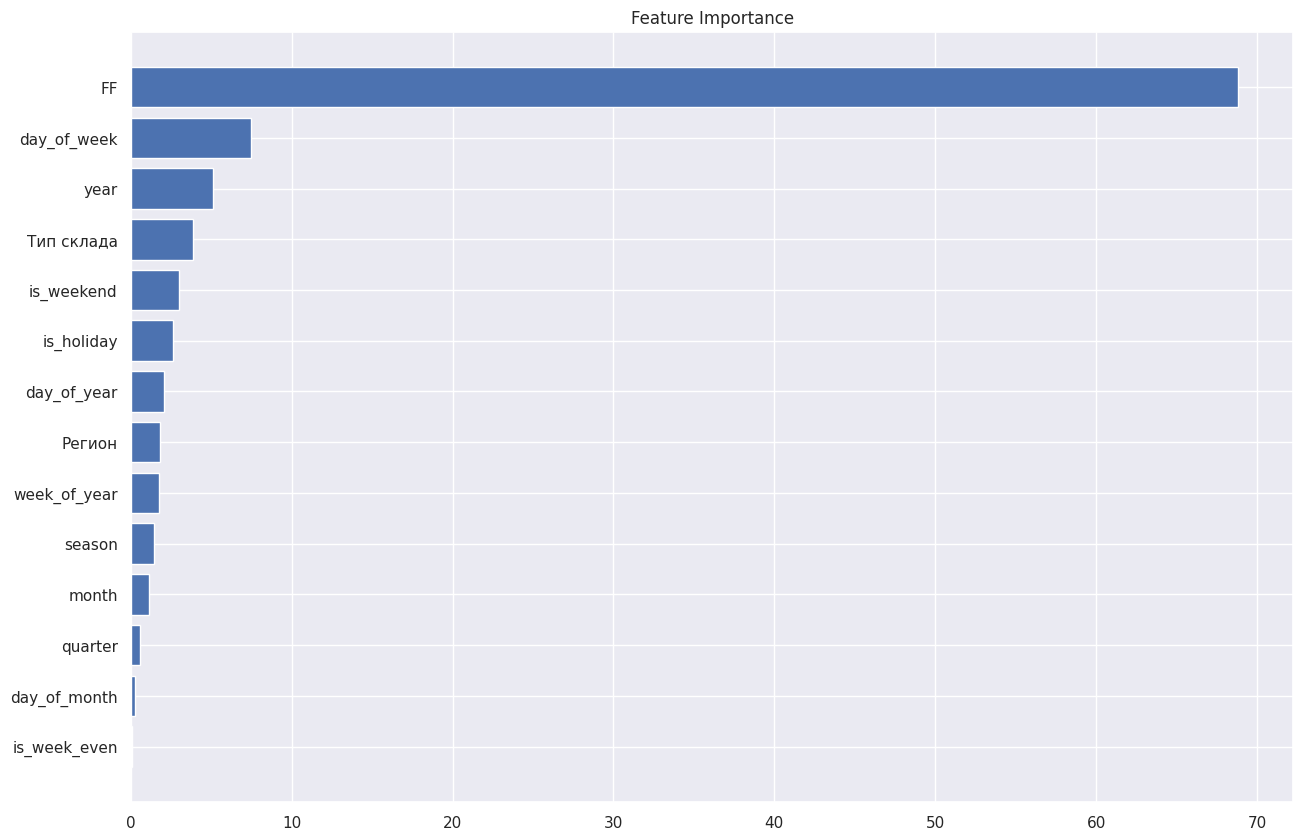

['FF' 'day_of_week' 'year' 'Тип склада' 'is_weekend' 'is_holiday'
 'day_of_year' 'Регион' 'week_of_year' 'season' 'month' 'quarter'
 'day_of_month' 'is_week_even']


In [22]:
boosting_2.show_feats_imp()

  0%|          | 0/14 [00:00<?, ?it/s]

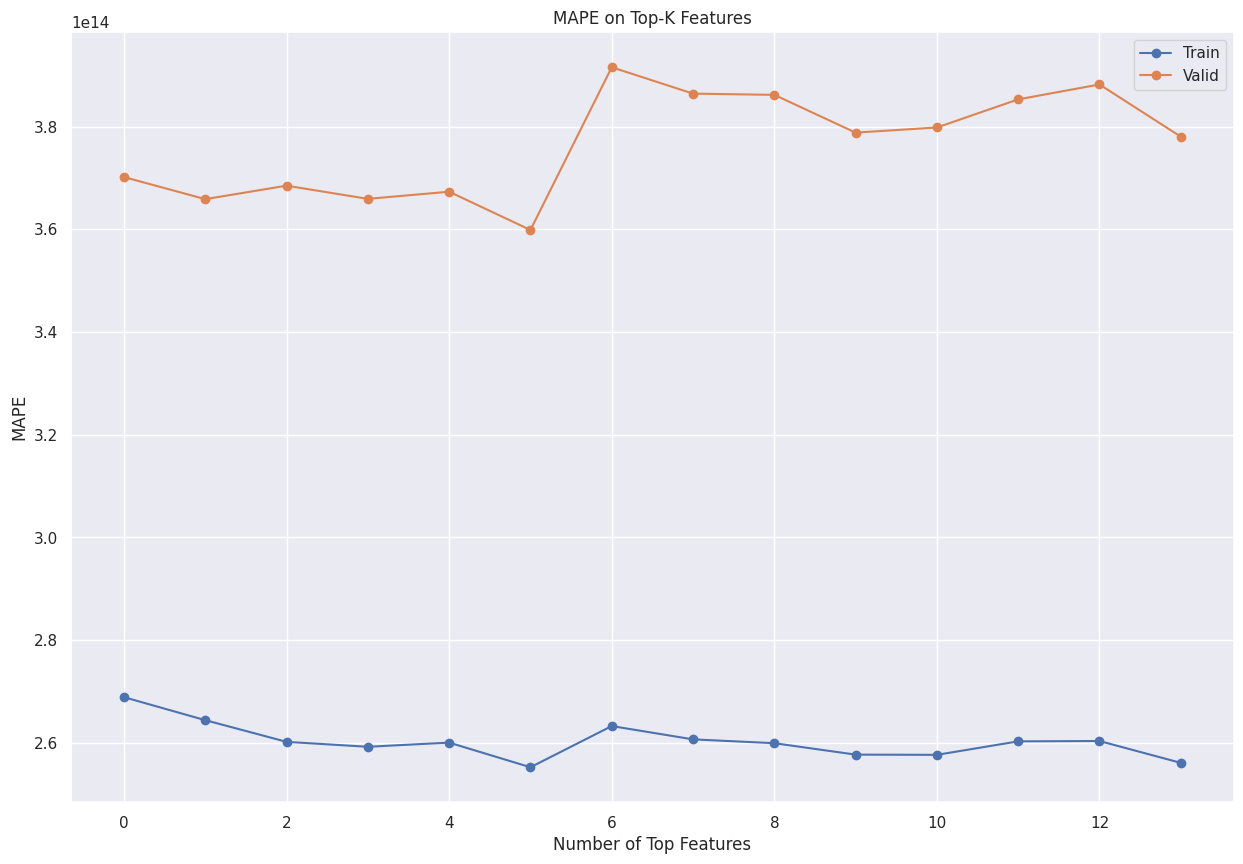

In [23]:
boosting_2.top_feats_selection()

In [24]:
boosting_2.save_model('boosting_2.pkl')

# Returns 3.0

In [25]:
boosting_3 = Boosting(
    X_train_3, 
    X_test_3, 
    np.log(y_train_3), 
    np.log(y_test_3), 
    cat_features = cat_features_3
)

Init...
Init Finished!


In [26]:
boosting_3.train()

Learning rate set to 0.040668
0:	learn: 0.0170959	test: -0.1370606	best: -0.1370606 (0)	total: 2.86ms	remaining: 5.72s
100:	learn: 0.3115767	test: 0.4465537	best: 0.4465537 (100)	total: 223ms	remaining: 4.19s
200:	learn: 0.3436814	test: 0.4877080	best: 0.4877080 (200)	total: 453ms	remaining: 4.06s
300:	learn: 0.3645441	test: 0.5069806	best: 0.5069806 (300)	total: 684ms	remaining: 3.86s
400:	learn: 0.3764556	test: 0.5121434	best: 0.5125260 (361)	total: 909ms	remaining: 3.63s
500:	learn: 0.3867260	test: 0.5166461	best: 0.5167017 (498)	total: 1.14s	remaining: 3.4s
600:	learn: 0.3971629	test: 0.5198939	best: 0.5204118 (595)	total: 1.37s	remaining: 3.19s
700:	learn: 0.4057153	test: 0.5208688	best: 0.5222686 (679)	total: 1.59s	remaining: 2.96s
800:	learn: 0.4149955	test: 0.5229101	best: 0.5233501 (790)	total: 1.84s	remaining: 2.76s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5233500798
bestIteration = 790

Shrink model to first 791 iterations.
MAPE на TRAIN выборке: 

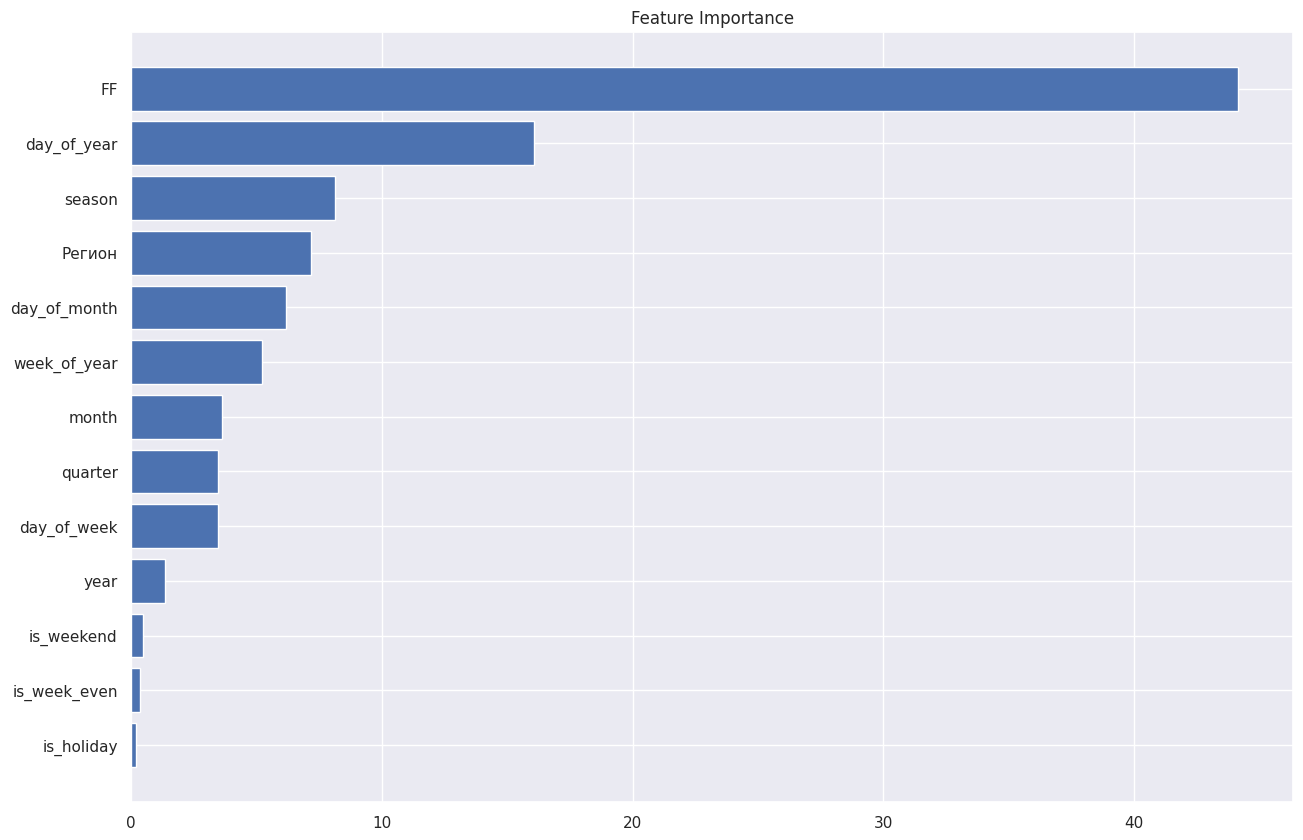

['FF' 'day_of_year' 'season' 'Регион' 'day_of_month' 'week_of_year'
 'month' 'quarter' 'day_of_week' 'year' 'is_weekend' 'is_week_even'
 'is_holiday']


In [27]:
boosting_3.show_feats_imp()

  0%|          | 0/13 [00:00<?, ?it/s]

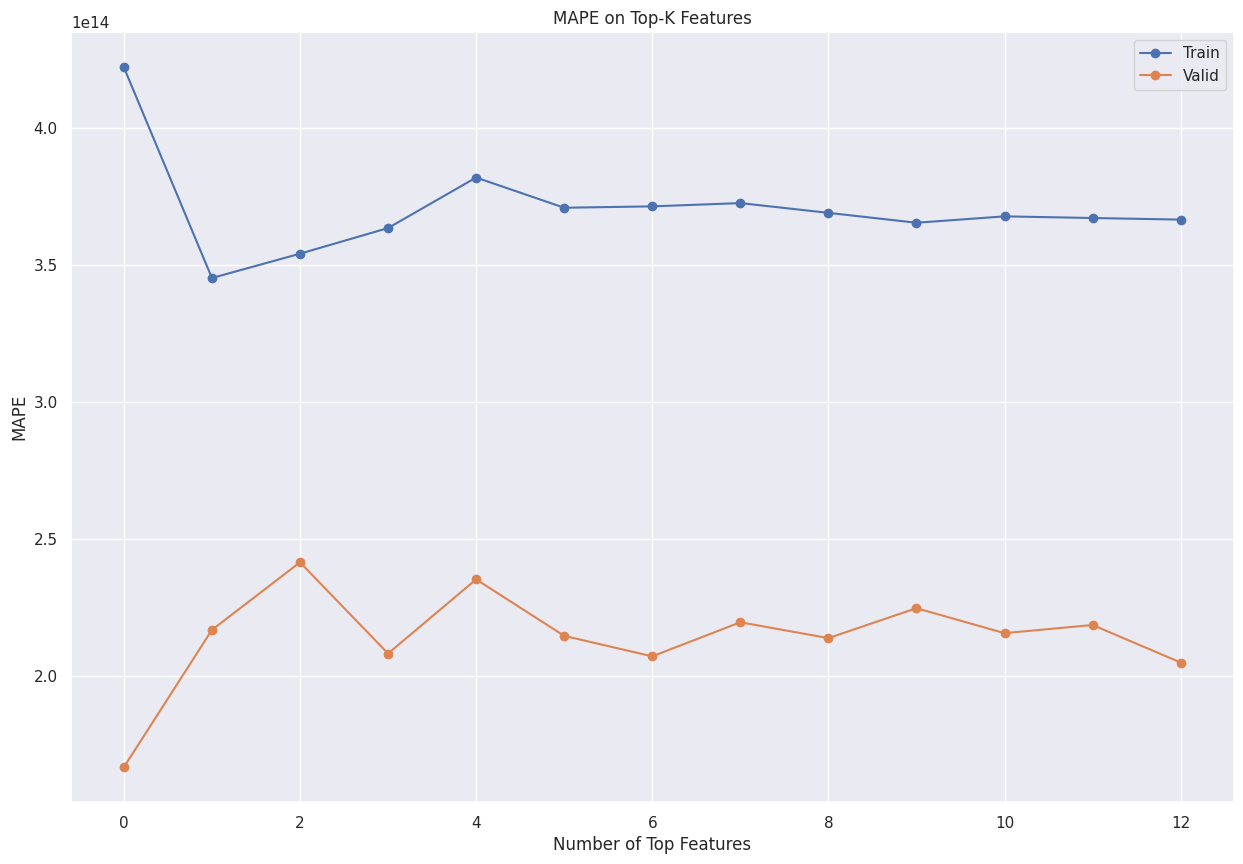

In [28]:
boosting_3.top_feats_selection()

In [29]:
boosting_3.save_model('boosting_3.pkl')

# Visualize Predictions

In [30]:
with open('/kaggle/working/boosting_2.pkl', 'rb') as f:
    model_2 = pickle.load(f)
    
with open('/kaggle/working/boosting_3.pkl', 'rb') as f:
    model_3 = pickle.load(f)

In [31]:
train_2 = df_2[df_2['day_id'] < '2024-01-01']
test_2 = df_2[df_2['day_id'] >= '2024-01-01']

train_3 = df_3[df_3['day_id'] < '2024-04-01']
test_3 = df_3[df_3['day_id'] >= '2024-01-01']

In [32]:
train_2['PREDS'] = np.exp(model_2.predict(train_2[model_2.feature_names_]))
test_2['PREDS'] = np.exp(model_2.predict(test_2[model_2.feature_names_]))

train_3['PREDS'] = np.exp(model_3.predict(train_3[model_3.feature_names_]))
test_3['PREDS'] = np.exp(model_3.predict(test_3[model_3.feature_names_]))

In [33]:
def visualize(group, pred, target, label):
    
    sns.set(style="darkgrid")
    plt.figure(figsize=(14, 7))
    plt.plot(group['day_id'], group[target], label='Target')
    plt.plot(group['day_id'], group[pred], label='Preds')
    plt.xlabel('Дата')
    plt.ylabel('Количество возвратов')
    plt.title(label)
    plt.legend()
    plt.show()

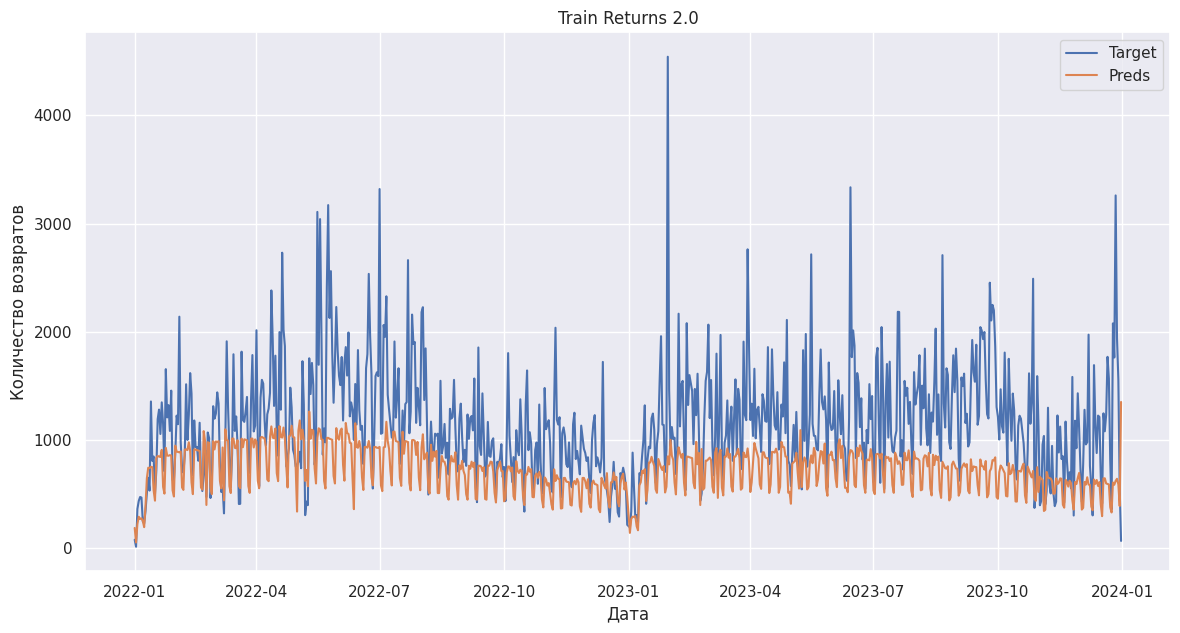

In [34]:
group = train_2.groupby('day_id').agg({
    'return_2_0_items' : 'mean',
    'PREDS' : 'mean'
}).reset_index()

visualize(group, 'PREDS', 'return_2_0_items', 'Train Returns 2.0')

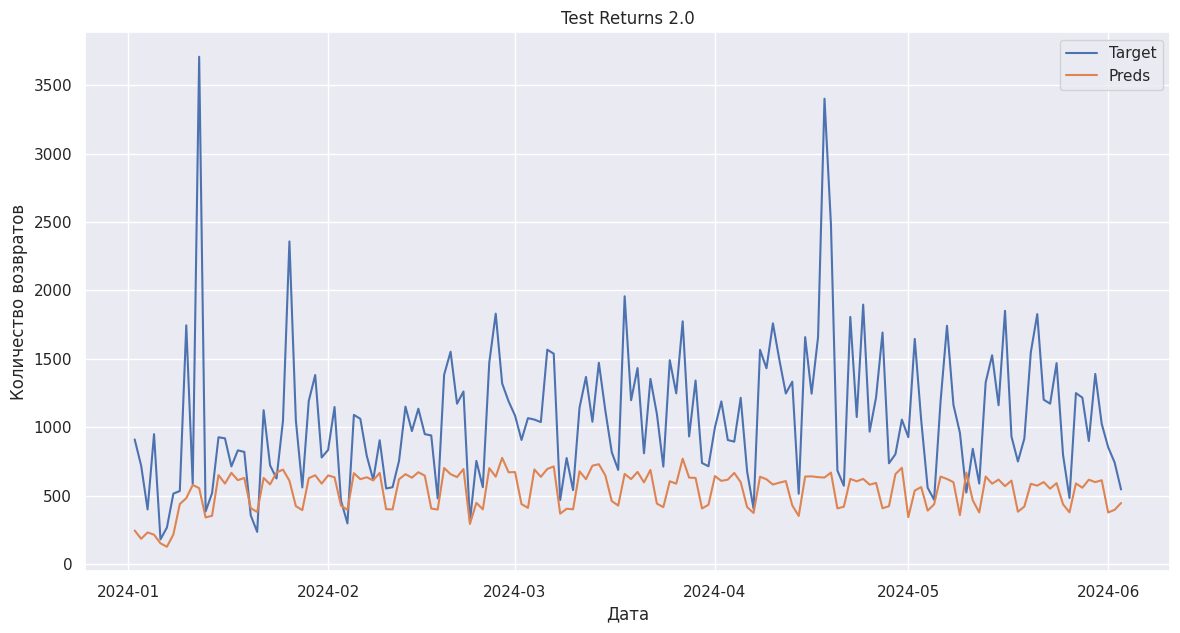

In [35]:
group = test_2.groupby('day_id').agg({
    'return_2_0_items' : 'mean',
    'PREDS' : 'mean'
}).reset_index()

visualize(group, 'PREDS', 'return_2_0_items', 'Test Returns 2.0')

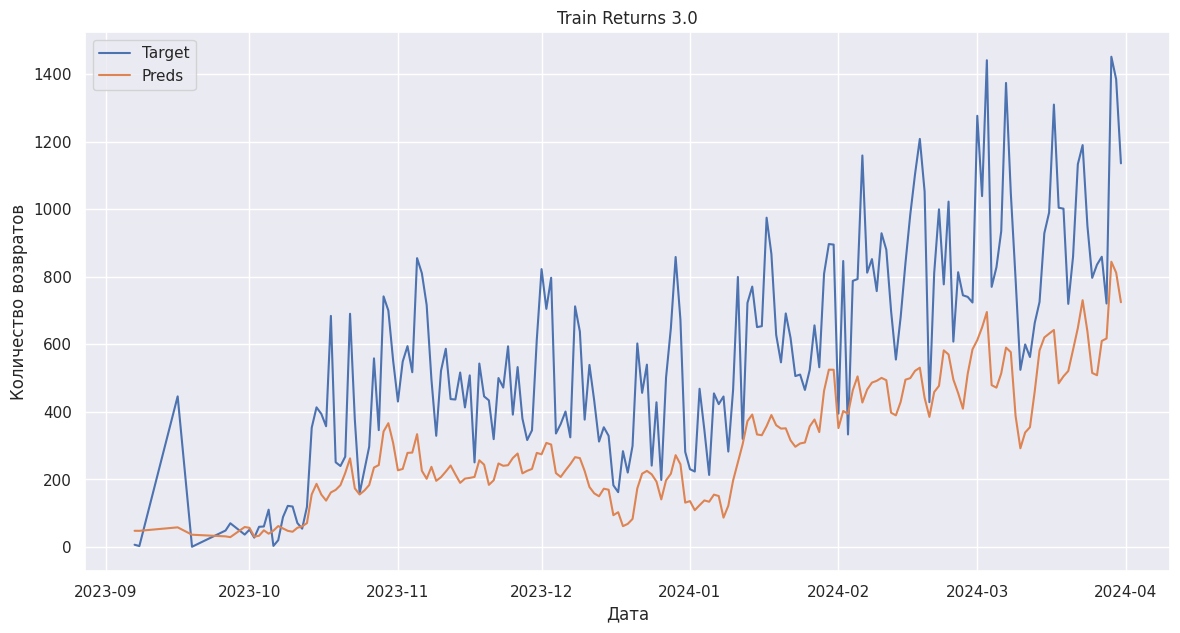

In [36]:
group = train_3.groupby('day_id').agg({
    'returns_3_0_items' : 'mean',
    'PREDS' : 'mean'
}).reset_index()

visualize(group, 'PREDS', 'returns_3_0_items', 'Train Returns 3.0')

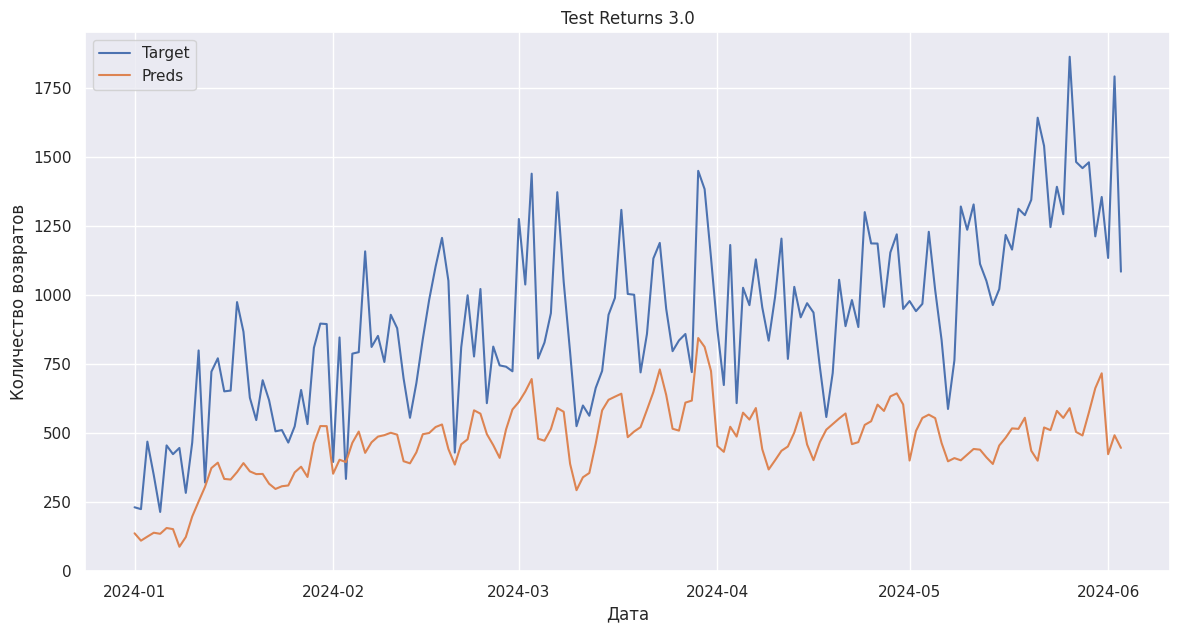

In [37]:
group = test_3.groupby('day_id').agg({
    'returns_3_0_items' : 'mean',
    'PREDS' : 'mean'
}).reset_index()

visualize(group, 'PREDS', 'returns_3_0_items', 'Test Returns 3.0')

# Predictions for 2024

In [38]:
def create_feature(day_id, storage_name):
    # creates row
    storage_features = df_1.loc[df_1['FF'] == storage_name].iloc[0][['Регион', 'Тип склада']].tolist()
    new_df = pd.DataFrame({'day_id': [pd.to_datetime(day_id)]})
    new_df[['Регион', 'Тип склада']] = df_1.loc[df_1['FF'] == storage_name].iloc[0][['Регион', 'Тип склада']]
    new_df['FF'] = storage_name
    # Add the specified features
    new_df['day_of_week'] = new_df['day_id'].dt.dayofweek
    new_df['month'] = new_df['day_id'].dt.month
    new_df['quarter'] = new_df['day_id'].dt.quarter
    new_df['day_of_month'] = new_df['day_id'].dt.day
    new_df['day_of_year'] = new_df['day_id'].dt.dayofyear
    new_df['week_of_year'] = new_df['day_id'].dt.isocalendar().week
    new_df['is_week_even'] = new_df['day_id'].dt.isocalendar().week % 2 == 0
    new_df['year'] = new_df['day_id'].dt.year
    new_df['is_weekend'] = new_df['day_id'].dt.dayofweek >= 5
    new_df['season'] = new_df['day_id'].apply(lambda x: (x.month % 12 + 3) // 3)

    # Map seasons to their names
    season_dict = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    new_df['season'] = new_df['season'].map(season_dict)

    # Define holiday dates
    holiday_dates = [
        "1 January",
        "2 January",
        "3 January",
        "4 January",
        "5 January",
        "6 January",
        "7 January",
        "8 January",
        "23 February",
        "8 March",
        "1 May",
        "9 May",
        "12 June",
        "4 November"
    ]

    holiday_set = set(holiday_dates)

    # Define a function to check if a date is a holiday
    def is_holiday(day):
        date_str = day.strftime("%-d %B")
        return date_str in holiday_set

    # Add is_holiday feature
    new_df['is_holiday'] = new_df['day_id'].apply(lambda x: 1 if is_holiday(x) else 0)
    return new_df


In [39]:
# Creating date range for end of year prediction
from datetime import datetime, timedelta

# Define start and end dates
start_date = datetime(2024, 6, 4)
end_date = datetime(2024, 12, 31)

# Generate the date range
date_range = []
current_date = start_date
while current_date <= end_date:
    date_range.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=1)


In [40]:
# Making predictions on refunds_2 

refunds_2_preds = []
storages = df_2['FF'].unique().tolist()

for day_id in tqdm(date_range):
    storages_pred = []
    for storage in storages:
        X = create_feature(day_id, storage)
        pred = np.exp(model_2.predict(X[model_2.feature_names_]))
        storages_pred.append(pred)
    refunds_2_preds.append(sum(storages_pred))

  0%|          | 0/211 [00:00<?, ?it/s]

In [41]:
X

,day_id,Регион,Тип склада,FF,day_of_week,month,quarter,day_of_month,day_of_year,week_of_year,is_week_even,year,is_weekend,season,is_holiday
0,2024-12-31,СНГ,Обычный,Склад 1045,1,12,4,31,366,1,False,2024,False,Winter,0


In [42]:
# Making predictions on refunds_3

refunds_3_preds = []
storages = df_3['FF'].unique().tolist()

for day_id in tqdm(date_range):
    storages_pred = []
    for storage in storages:
        X = create_feature(day_id, storage)
        pred = np.exp(model_3.predict(X[model_3.feature_names_]))
        storages_pred.append(pred)
    refunds_3_preds.append(sum(storages_pred))

  0%|          | 0/211 [00:00<?, ?it/s]

# Задания

## 1 Средний объем возвратов 2.0/3.0 на конец года
## Ответ: 3.74 Мы видим, что в сравнении с 2023 годом, соотношение  возвратов 2.0 к 3.0 уменьшится примерно на 26%, что означает подтверждение поставленной раннее гипотезы

In [43]:
print(f'{np.sum(refunds_2_preds)/np.sum(refunds_3_preds)}')

3.7407937290356084


In [44]:
s1 = df_2.loc[(df_2['day_id'] >= '2023-09-07') & (df_2['day_id'] <= '2023-12-31')]['return_2_0_items'].sum()

In [45]:
s2 = df_3.loc[(df_3['day_id'] >= '2023-01-01') & (df_3['day_id'] <= '2023-12-31')]['returns_3_0_items'].sum()

In [46]:
s1/ s2

5.095813918701619

In [47]:
1 - 3.74 / (s1 / s2) 

0.2660642520178743

## 2 На какой неделе будет максимальный объем возвратов?
## Ответ: 23 июня 2024 года - 30 июня 2024 года. Объем возвратов составляет 225 089

In [48]:
all_refunds = [refunds_2_preds[i] + refunds_3_preds[i] for i in range(len(refunds_2_preds))]

curr_sum = 0
start = 0
for i in range(0, len(all_refunds) - 6):
    if sum(all_refunds[i : i + 7]) > curr_sum:
        start = i
        curr_sum = sum(all_refunds[i : i + 7]) 


## 3 Какой % возвраты 3.0 составляют от общего кол-ва возвратов
## Ответ: 21%

In [49]:
print(f'{100 * np.sum(refunds_3_preds) / (np.sum(refunds_2_preds) + np.sum(refunds_3_preds))} % ')

21.093514233183566 % 
